## 1.生成train 和validation数据

#### 需要预测的时间是从2015年8月1日到9月17日，考虑到季度问题，所以提取出2014年7月1日到12月31日来测试

In [33]:
import pandas as pd
import numpy as np
import rossmann as ross
from time import time
train= pd.read_csv('train_feature.csv',parse_dates=[12],low_memory=False)
test = pd.read_csv('test_feature.csv',parse_dates=[11],low_memory=False)

In [34]:
train.shape

(844392, 31)

In [35]:
ross.rossmann_test()

rossmann package


#### 检查数据的倾斜度

In [36]:
from scipy import stats
import matplotlib.pyplot as plt

In [37]:
train.drop(train[train.Sales == 0].index, inplace = True)

In [38]:
stats.mstats.skew(train['Sales']).data

array(1.594926)

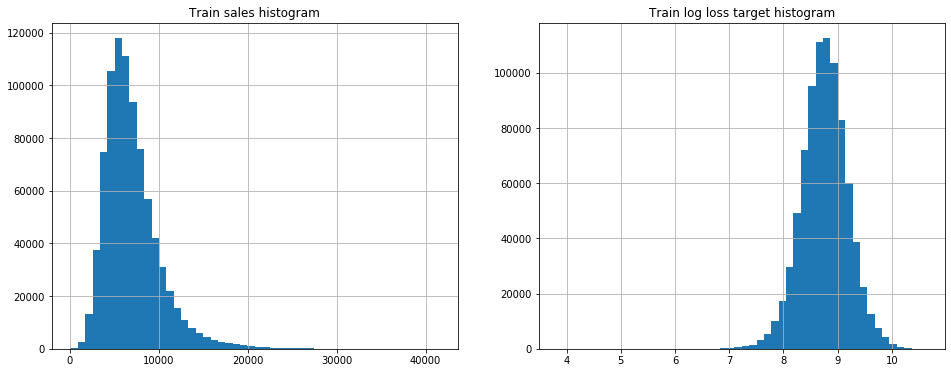

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,6)
ax1.hist(train['Sales'],bins=50)
ax1.set_title('Train sales histogram')
ax1.grid(True)
ax2.hist(np.log(train['Sales']),bins=50)
ax2.set_title('Train log loss target histogram')
ax2.grid(True)
plt.show()

In [40]:
train.Sales = np.log1p(train.Sales)

In [41]:
stats.mstats.skew(train['Sales']).data

array(-0.10932675)

#### 对数据进行对数变换，改善了数据的偏度情况

In [42]:
test.head()

,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StateHoliday_a,Id,Store,...,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromoMonth
0,0,0,1,0,1,0,0,0,1,1,...,0,14.0,2011.0,2015,9,17,38,84.0,0.0,0
1,0,0,1,0,1,0,0,0,857,1,...,0,14.0,2011.0,2015,9,16,38,84.0,0.0,0
2,0,0,1,0,1,0,0,0,1713,1,...,0,14.0,2011.0,2015,9,15,38,84.0,0.0,0
3,0,0,1,0,1,0,0,0,2569,1,...,0,14.0,2011.0,2015,9,14,38,84.0,0.0,0
4,0,0,1,0,1,0,0,0,3425,1,...,0,14.0,2011.0,2015,9,13,37,84.0,0.0,0


In [43]:
#### 需要预测的时间是从2015年8月1日到9月17日，考虑到季度问题，所以提取出2014年7月1日到12月31日来测试
train_tra = train[(train['Date'] >= '2015-01-01 00:00:00') | (train['Date'] <= '2014-07-01 00:00:00')]

In [44]:
train_val = train[(train['Date'] > '2014-07-01 00:00:00') & (train['Date'] < '2015-01-01 00:00:00')]

In [45]:
train.shape

(844338, 31)

In [46]:
train_tra.shape

(700535, 31)

In [47]:
train_val.shape

(143803, 31)

In [48]:
train_val.columns

Index(['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c', 'StateHoliday_a',
       'StateHoliday_b', 'StateHoliday_c', 'Store', 'DayOfWeek', 'Date',
       'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'Day', 'WeekOfYear',
       'CompetitionOpen', 'Promo2Open', 'IsPromoMonth'],
      dtype='object')

In [49]:
### 删除掉在测试集中没有的Customer列
train_val = train_val.drop(['Customers'],axis=1)
train_tra = train_tra.drop(['Customers'],axis=1)

In [50]:
### 删除Open
train_val = train_val.drop(['Open'],axis=1)
train_tra = train_tra.drop(['Open'],axis=1)
test = test.drop(['Open'],axis=1)

In [51]:
### 删除掉data
train_val = train_val.drop(['Date'],axis=1)
train_tra = train_tra.drop(['Date'],axis=1)
test = test.drop(['Date'],axis=1)

In [52]:
train_val.to_csv('train_val.csv', sep=',', encoding='utf-8', index=False)
train_tra.to_csv('train_tra.csv',sep=',', encoding='utf-8', index = False)
test.to_csv('test_done.csv',sep=',',encoding='utf-8', index=False)

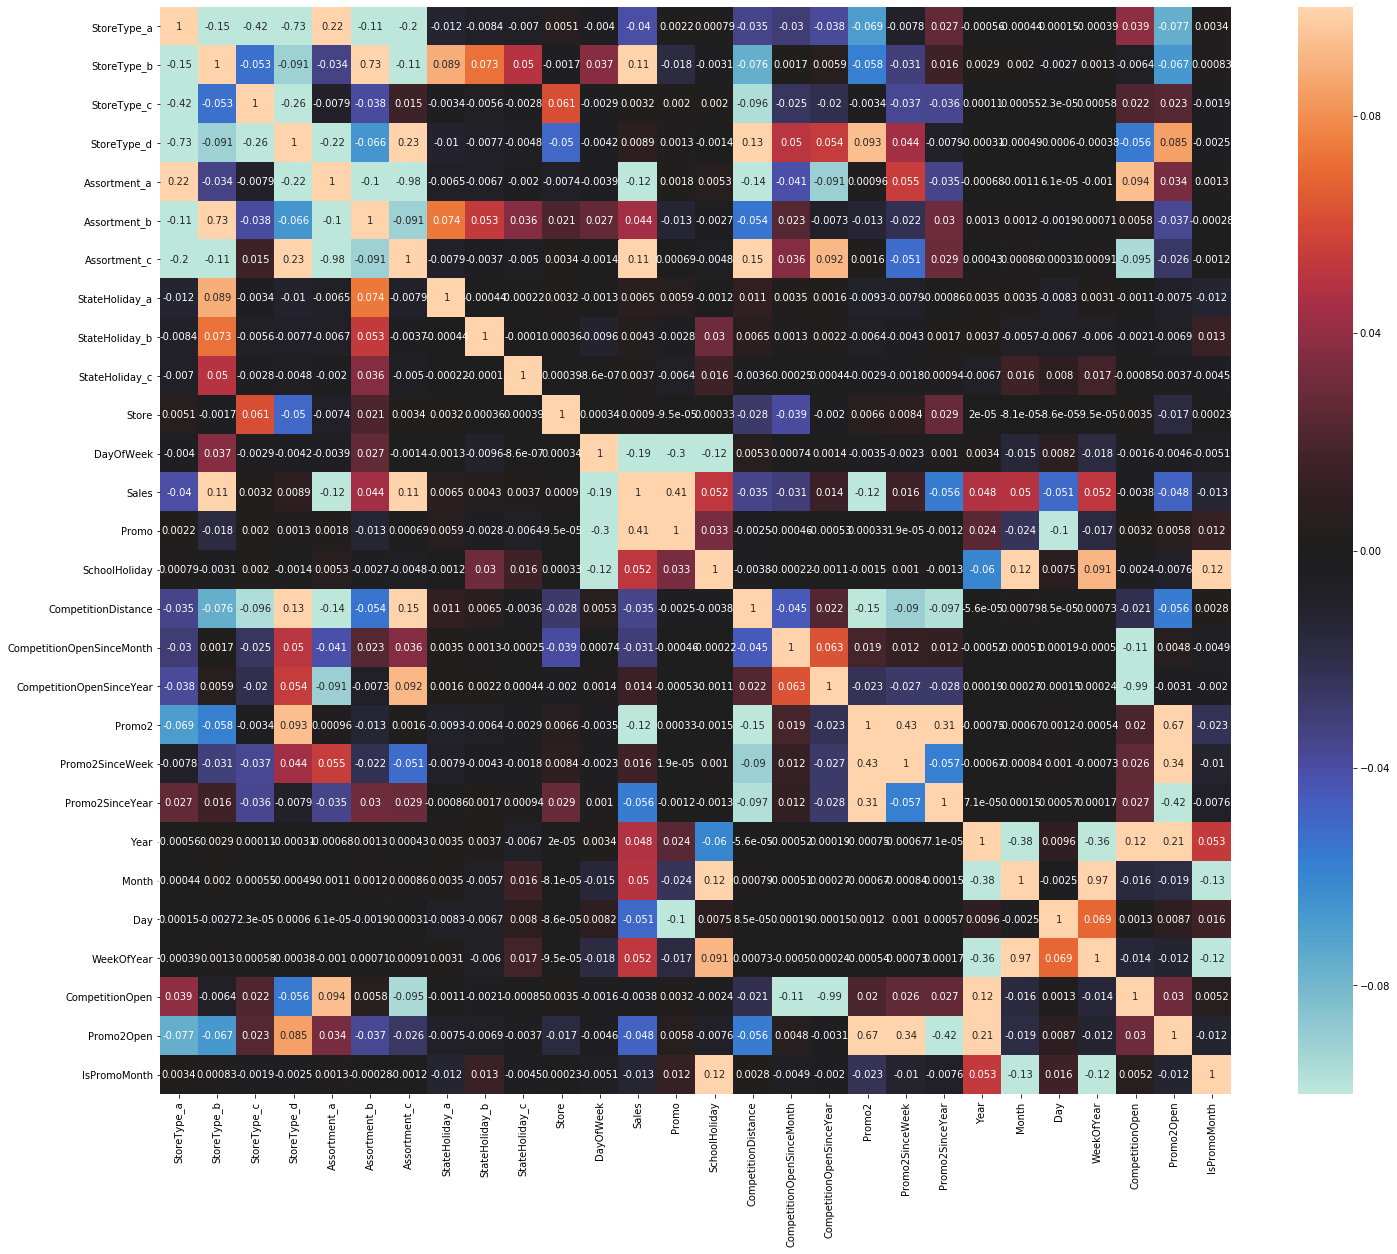

In [53]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(24,20))

sns.heatmap(train_tra.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)

In [54]:
# 拆分特征和标签
train_tra_x = train_tra.drop(['Sales'], axis=1)
train_tra_y = train_tra['Sales']

train_val_x = train_val.drop(['Sales'], axis=1)
train_val_y = train_val['Sales']


### 模型尝试：1.决策树

In [55]:
# 使用简单的DECISTIONTREE来拟合
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(train_tra_x, train_tra_y)

In [56]:
print("validating")
train_val_x.sort_index(inplace=True) 
train_val_y.sort_index(inplace=True) 
#clf.predict(ho_xtest)
y_predict = clf.predict(train_val_x)

error = ross.rmspe(train_val_y, y_predict)

print('RMSPE: {:.6f}'.format(error))

validating
RMSPE: 0.328742


### 模型尝试：2.随机森林

In [25]:
%%time 

from sklearn.ensemble import RandomForestRegressor

randomForest_model = RandomForestRegressor(n_estimators=100)
randomForest_model.fit(train_tra_x, train_tra_y)

Wall time: 9min 21s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [27]:
%%time 

print("validating")
#clf.predict(ho_xtest)
y_predict = randomForest_model.predict(train_val_x)

error = ross.rmspe(train_val_y, y_predict)

print('RMSPE: {:.6f}'.format(error))

validating
RMSPE: 0.304544
Wall time: 13.1 s


### 模型尝试 ：3.XGBOOST

In [59]:
import xgboost as xgb


In [61]:
params1 = {"objective": "reg:linear",
          "booster" : "gbtree",
          "seed": 0,
          }
num_boost_round = 1000

In [62]:
dtrain = xgb.DMatrix(train_tra_x, train_tra_y)

D:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [63]:
dvalid = xgb.DMatrix(train_val_x, train_val_y)

In [64]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [65]:
%%time

gbm = xgb.train(params1, dtrain, num_boost_round,
                feval=rmspe_xg, maximize=False,early_stopping_rounds=100, verbose_eval=True,evals=watchlist)

[11:08:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5.78916	eval-rmse:5.82359	train-rmspe:393.784	eval-rmspe:408.375
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06014	eval-rmse:4.08788	train-rmspe:64.9616	eval-rmspe:66.9146
[2]	train-rmse:2.85286	eval-rmse:2.87281	train-rmspe:18.3579	eval-rmspe:18.7643
[3]	train-rmse:2.01158	eval-rmse:2.02881	train-rmspe:7.25292	eval-rmspe:7.41353
[4]	train-rmse:1.42835	eval-rmse:1.4404	train-rmspe:3.56951	eval-rmspe:3.6222
[5]	train-rmse:1.02783	eval-rmse:1.02923	train-rmspe:2.04075	eval-rmspe:2.04454
[6]	train-rmse:0.756135	eval-rmse:0.755499	train-rmspe:1.29447	eval-rmspe:1.29369
[7]	train-rmse:0.576652	eval-rmse:0.576511	train-rmspe:0.896919	eval-rmspe:0.897865
[8]	train-rmse:0.463632	eval-rmse:0.457814	train-rmspe:0.675234	eval-rmspe:0.665477
[9]	train-

[95]	train-rmse:0.15908	eval-rmse:0.172855	train-rmspe:0.161015	eval-rmspe:0.179815
[96]	train-rmse:0.157766	eval-rmse:0.17166	train-rmspe:0.159781	eval-rmspe:0.178769
[97]	train-rmse:0.157171	eval-rmse:0.171043	train-rmspe:0.15916	eval-rmspe:0.178149
[98]	train-rmse:0.156067	eval-rmse:0.170216	train-rmspe:0.158088	eval-rmspe:0.177286
[99]	train-rmse:0.155479	eval-rmse:0.16974	train-rmspe:0.15747	eval-rmspe:0.176825
[100]	train-rmse:0.154407	eval-rmse:0.168629	train-rmspe:0.156359	eval-rmspe:0.175768
[101]	train-rmse:0.154237	eval-rmse:0.168623	train-rmspe:0.156154	eval-rmspe:0.175632
[102]	train-rmse:0.153576	eval-rmse:0.168616	train-rmspe:0.155378	eval-rmspe:0.175566
[103]	train-rmse:0.152779	eval-rmse:0.167969	train-rmspe:0.154568	eval-rmspe:0.174869
[104]	train-rmse:0.152332	eval-rmse:0.167592	train-rmspe:0.154133	eval-rmspe:0.174505
[105]	train-rmse:0.151883	eval-rmse:0.167361	train-rmspe:0.153649	eval-rmspe:0.175028
[106]	train-rmse:0.151213	eval-rmse:0.166908	train-rmspe:0.15294

[191]	train-rmse:0.124635	eval-rmse:0.148007	train-rmspe:0.125904	eval-rmspe:0.156171
[192]	train-rmse:0.124559	eval-rmse:0.147939	train-rmspe:0.125828	eval-rmspe:0.156126
[193]	train-rmse:0.124458	eval-rmse:0.147899	train-rmspe:0.125729	eval-rmspe:0.156088
[194]	train-rmse:0.124242	eval-rmse:0.147629	train-rmspe:0.125496	eval-rmspe:0.15581
[195]	train-rmse:0.123967	eval-rmse:0.1474	train-rmspe:0.125209	eval-rmspe:0.155569
[196]	train-rmse:0.123819	eval-rmse:0.147325	train-rmspe:0.125071	eval-rmspe:0.155507
[197]	train-rmse:0.123583	eval-rmse:0.147163	train-rmspe:0.124844	eval-rmspe:0.155372
[198]	train-rmse:0.123488	eval-rmse:0.147109	train-rmspe:0.124752	eval-rmspe:0.155315
[199]	train-rmse:0.123292	eval-rmse:0.146986	train-rmspe:0.124557	eval-rmspe:0.155306
[200]	train-rmse:0.123032	eval-rmse:0.146803	train-rmspe:0.124302	eval-rmspe:0.155162
[201]	train-rmse:0.122992	eval-rmse:0.146795	train-rmspe:0.12426	eval-rmspe:0.155154
[202]	train-rmse:0.122916	eval-rmse:0.146759	train-rmspe:0

[287]	train-rmse:0.112707	eval-rmse:0.142189	train-rmspe:0.113791	eval-rmspe:0.150602
[288]	train-rmse:0.112555	eval-rmse:0.142099	train-rmspe:0.113644	eval-rmspe:0.150548
[289]	train-rmse:0.11242	eval-rmse:0.14201	train-rmspe:0.113511	eval-rmspe:0.150478
[290]	train-rmse:0.112392	eval-rmse:0.141999	train-rmspe:0.113484	eval-rmspe:0.150459
[291]	train-rmse:0.112277	eval-rmse:0.141984	train-rmspe:0.113364	eval-rmspe:0.150448
[292]	train-rmse:0.112173	eval-rmse:0.141893	train-rmspe:0.113256	eval-rmspe:0.150371
[293]	train-rmse:0.112062	eval-rmse:0.141836	train-rmspe:0.113145	eval-rmspe:0.150298
[294]	train-rmse:0.111988	eval-rmse:0.141822	train-rmspe:0.113062	eval-rmspe:0.150259
[295]	train-rmse:0.111939	eval-rmse:0.141805	train-rmspe:0.113012	eval-rmspe:0.150237
[296]	train-rmse:0.111807	eval-rmse:0.14171	train-rmspe:0.112881	eval-rmspe:0.150147
[297]	train-rmse:0.111763	eval-rmse:0.141715	train-rmspe:0.112843	eval-rmspe:0.15012
[298]	train-rmse:0.111697	eval-rmse:0.141658	train-rmspe:0

[383]	train-rmse:0.105167	eval-rmse:0.138184	train-rmspe:0.105864	eval-rmspe:0.147465
[384]	train-rmse:0.105108	eval-rmse:0.138163	train-rmspe:0.105794	eval-rmspe:0.147468
[385]	train-rmse:0.105024	eval-rmse:0.138109	train-rmspe:0.1057	eval-rmspe:0.147422
[386]	train-rmse:0.104985	eval-rmse:0.138091	train-rmspe:0.105665	eval-rmspe:0.147417
[387]	train-rmse:0.104825	eval-rmse:0.137982	train-rmspe:0.105526	eval-rmspe:0.14735
[388]	train-rmse:0.104812	eval-rmse:0.137984	train-rmspe:0.105515	eval-rmspe:0.147346
[389]	train-rmse:0.104736	eval-rmse:0.137922	train-rmspe:0.105439	eval-rmspe:0.147303
[390]	train-rmse:0.104701	eval-rmse:0.137927	train-rmspe:0.105405	eval-rmspe:0.147375
[391]	train-rmse:0.104669	eval-rmse:0.137916	train-rmspe:0.105373	eval-rmspe:0.147364
[392]	train-rmse:0.104595	eval-rmse:0.138116	train-rmspe:0.105307	eval-rmspe:0.147594
[393]	train-rmse:0.104545	eval-rmse:0.13808	train-rmspe:0.105255	eval-rmspe:0.147558
[394]	train-rmse:0.104515	eval-rmse:0.138066	train-rmspe:0

[479]	train-rmse:0.100378	eval-rmse:0.136767	train-rmspe:0.100836	eval-rmspe:0.146367
[480]	train-rmse:0.100359	eval-rmse:0.13678	train-rmspe:0.100815	eval-rmspe:0.146401
[481]	train-rmse:0.100278	eval-rmse:0.136979	train-rmspe:0.100733	eval-rmspe:0.146513
[482]	train-rmse:0.100228	eval-rmse:0.136955	train-rmspe:0.100681	eval-rmspe:0.146494
[483]	train-rmse:0.100201	eval-rmse:0.136906	train-rmspe:0.100652	eval-rmspe:0.146371
[484]	train-rmse:0.100142	eval-rmse:0.13686	train-rmspe:0.100583	eval-rmspe:0.146352
[485]	train-rmse:0.100107	eval-rmse:0.136854	train-rmspe:0.100549	eval-rmspe:0.146346
[486]	train-rmse:0.099988	eval-rmse:0.136821	train-rmspe:0.100416	eval-rmspe:0.146315
[487]	train-rmse:0.099959	eval-rmse:0.136812	train-rmspe:0.100391	eval-rmspe:0.146308
[488]	train-rmse:0.099943	eval-rmse:0.136816	train-rmspe:0.100374	eval-rmspe:0.146306
[489]	train-rmse:0.099882	eval-rmse:0.136752	train-rmspe:0.100307	eval-rmspe:0.146244
[490]	train-rmse:0.099857	eval-rmse:0.13677	train-rmspe:

[575]	train-rmse:0.097052	eval-rmse:0.135945	train-rmspe:0.097237	eval-rmspe:0.145675
[576]	train-rmse:0.097022	eval-rmse:0.135912	train-rmspe:0.097202	eval-rmspe:0.145623
[577]	train-rmse:0.096979	eval-rmse:0.135899	train-rmspe:0.097162	eval-rmspe:0.145618
[578]	train-rmse:0.096923	eval-rmse:0.135877	train-rmspe:0.097096	eval-rmspe:0.145599
[579]	train-rmse:0.096892	eval-rmse:0.135871	train-rmspe:0.097069	eval-rmspe:0.145597
[580]	train-rmse:0.096861	eval-rmse:0.135875	train-rmspe:0.097035	eval-rmspe:0.145609
[581]	train-rmse:0.096822	eval-rmse:0.135855	train-rmspe:0.096996	eval-rmspe:0.145586
[582]	train-rmse:0.096805	eval-rmse:0.135849	train-rmspe:0.096978	eval-rmspe:0.145589
[583]	train-rmse:0.096763	eval-rmse:0.135833	train-rmspe:0.096936	eval-rmspe:0.145585
[584]	train-rmse:0.096663	eval-rmse:0.135778	train-rmspe:0.096844	eval-rmspe:0.145531
[585]	train-rmse:0.096596	eval-rmse:0.135744	train-rmspe:0.096778	eval-rmspe:0.1455
[586]	train-rmse:0.09655	eval-rmse:0.135727	train-rmspe:

[671]	train-rmse:0.094219	eval-rmse:0.135294	train-rmspe:0.094132	eval-rmspe:0.144898
[672]	train-rmse:0.094189	eval-rmse:0.135284	train-rmspe:0.094099	eval-rmspe:0.144899
[673]	train-rmse:0.094152	eval-rmse:0.135273	train-rmspe:0.094062	eval-rmspe:0.144888
[674]	train-rmse:0.094117	eval-rmse:0.135262	train-rmspe:0.094025	eval-rmspe:0.144881
[675]	train-rmse:0.09408	eval-rmse:0.135274	train-rmspe:0.093981	eval-rmspe:0.144883
[676]	train-rmse:0.094043	eval-rmse:0.135247	train-rmspe:0.093951	eval-rmspe:0.144844
[677]	train-rmse:0.094015	eval-rmse:0.135229	train-rmspe:0.093921	eval-rmspe:0.144846
[678]	train-rmse:0.093946	eval-rmse:0.135404	train-rmspe:0.093798	eval-rmspe:0.144886
[679]	train-rmse:0.093917	eval-rmse:0.135771	train-rmspe:0.093763	eval-rmspe:0.144951
[680]	train-rmse:0.093883	eval-rmse:0.135782	train-rmspe:0.093687	eval-rmspe:0.144955
[681]	train-rmse:0.093867	eval-rmse:0.135799	train-rmspe:0.093673	eval-rmspe:0.144982
[682]	train-rmse:0.093856	eval-rmse:0.135785	train-rmsp

[767]	train-rmse:0.092054	eval-rmse:0.135222	train-rmspe:0.091764	eval-rmspe:0.144703
[768]	train-rmse:0.092012	eval-rmse:0.135234	train-rmspe:0.091721	eval-rmspe:0.144746
[769]	train-rmse:0.092001	eval-rmse:0.135234	train-rmspe:0.09171	eval-rmspe:0.144753
[770]	train-rmse:0.091979	eval-rmse:0.135225	train-rmspe:0.091687	eval-rmspe:0.144735
[771]	train-rmse:0.091939	eval-rmse:0.13541	train-rmspe:0.091649	eval-rmspe:0.144866
[772]	train-rmse:0.091918	eval-rmse:0.135392	train-rmspe:0.09163	eval-rmspe:0.144865
[773]	train-rmse:0.091885	eval-rmse:0.135383	train-rmspe:0.091596	eval-rmspe:0.144856
[774]	train-rmse:0.091866	eval-rmse:0.135286	train-rmspe:0.091574	eval-rmspe:0.144843
[775]	train-rmse:0.091835	eval-rmse:0.135316	train-rmspe:0.091534	eval-rmspe:0.144866
[776]	train-rmse:0.091807	eval-rmse:0.135292	train-rmspe:0.091507	eval-rmspe:0.144483
[777]	train-rmse:0.09178	eval-rmse:0.135268	train-rmspe:0.091477	eval-rmspe:0.144441
[778]	train-rmse:0.091768	eval-rmse:0.135267	train-rmspe:0

[863]	train-rmse:0.090089	eval-rmse:0.134691	train-rmspe:0.089695	eval-rmspe:0.143864
[864]	train-rmse:0.090067	eval-rmse:0.13471	train-rmspe:0.089671	eval-rmspe:0.143884
[865]	train-rmse:0.090046	eval-rmse:0.134708	train-rmspe:0.089653	eval-rmspe:0.143877
[866]	train-rmse:0.090032	eval-rmse:0.134697	train-rmspe:0.089638	eval-rmspe:0.143867
[867]	train-rmse:0.090019	eval-rmse:0.13467	train-rmspe:0.089629	eval-rmspe:0.143866
[868]	train-rmse:0.089997	eval-rmse:0.134668	train-rmspe:0.089605	eval-rmspe:0.143865
[869]	train-rmse:0.08997	eval-rmse:0.13467	train-rmspe:0.089578	eval-rmspe:0.143853
[870]	train-rmse:0.089933	eval-rmse:0.134648	train-rmspe:0.089536	eval-rmspe:0.143835
[871]	train-rmse:0.089921	eval-rmse:0.134652	train-rmspe:0.089523	eval-rmspe:0.143855
[872]	train-rmse:0.089908	eval-rmse:0.134648	train-rmspe:0.08951	eval-rmspe:0.143845
[873]	train-rmse:0.089875	eval-rmse:0.134637	train-rmspe:0.089476	eval-rmspe:0.143837
[874]	train-rmse:0.089867	eval-rmse:0.134625	train-rmspe:0.

[959]	train-rmse:0.088445	eval-rmse:0.134	train-rmspe:0.087947	eval-rmspe:0.143352
[960]	train-rmse:0.08844	eval-rmse:0.134003	train-rmspe:0.087943	eval-rmspe:0.143352
[961]	train-rmse:0.088428	eval-rmse:0.133994	train-rmspe:0.087931	eval-rmspe:0.143333
[962]	train-rmse:0.088424	eval-rmse:0.133991	train-rmspe:0.087927	eval-rmspe:0.143331
[963]	train-rmse:0.088413	eval-rmse:0.133994	train-rmspe:0.087916	eval-rmspe:0.143335
[964]	train-rmse:0.088394	eval-rmse:0.134019	train-rmspe:0.087901	eval-rmspe:0.143335
[965]	train-rmse:0.088384	eval-rmse:0.134026	train-rmspe:0.087891	eval-rmspe:0.143341
[966]	train-rmse:0.088356	eval-rmse:0.134006	train-rmspe:0.087844	eval-rmspe:0.143304
[967]	train-rmse:0.088345	eval-rmse:0.134005	train-rmspe:0.087832	eval-rmspe:0.143293
[968]	train-rmse:0.088331	eval-rmse:0.134006	train-rmspe:0.087817	eval-rmspe:0.143293
[969]	train-rmse:0.088321	eval-rmse:0.133996	train-rmspe:0.087806	eval-rmspe:0.143282
[970]	train-rmse:0.088314	eval-rmse:0.133993	train-rmspe:0

In [66]:
#采用保留数据集进行检测
print("validating")
yhat = gbm.predict(xgb.DMatrix(train_tra_x))
error = ross.rmspe(train_tra_y, yhat)

print('RMSPE: {:.6f}'.format(error))

validating
RMSPE: 0.112496


### 使用 XGBOOST的效果好于其他模型

In [69]:
%%time

bst_cv1 = xgb.cv(params1, dtrain, num_boost_round, nfold=3,
                feval=rmspe_xg, maximize=False,early_stopping_rounds=100, verbose_eval=True)

[11:14:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5.78923+0.000445262	train-rmspe:394.061+0.218917	test-rmse:5.78922+0.00119754	test-rmspe:394.071+0.333735
[1]	train-rmse:4.06027+0.000320418	train-rmspe:65.0072+0.0318814	test-rmse:4.06025+0.00116473	test-rmspe:65.0098+0.0521626
[2]	train-rmse:2.85302+0.000233777	train-rmspe:18.3767+0.00817871	test-rmse:2.85303+0.00110293	test-rmspe:18.3783+0.0149991
[3]	train-rmse:2.01174+0.00018972	train-rmspe:7.25974+0.00266483	test-rmse:2.01174+0.000990455	test-rmspe:7.26023+0.00613073
[4]	train-rmse:1.42857+0.000146552	train-rmspe:3.57309+0.00137878	test-rmse:1.42859+0.00100862	test-rmspe:3.57356+0.00354673
[5]	train-rmse:1.02792+0.000214849

[62]	train-rmse:0.188107+0.00176414	train-rmspe:0.192289+0.00212511	test-rmse:0.189213+0.00129834	test-rmspe:0.193582+0.00201059
[63]	train-rmse:0.186238+0.00217229	train-rmspe:0.190239+0.00260637	test-rmse:0.187332+0.00187779	test-rmspe:0.191513+0.00253282
[64]	train-rmse:0.18508+0.0020206	train-rmspe:0.18904+0.00243021	test-rmse:0.186168+0.00183607	test-rmspe:0.190338+0.0022536
[65]	train-rmse:0.183984+0.00199979	train-rmspe:0.187822+0.00233979	test-rmse:0.18512+0.0018274	test-rmspe:0.189225+0.00215995
[66]	train-rmse:0.182933+0.00151043	train-rmspe:0.186677+0.00186269	test-rmse:0.184068+0.00139265	test-rmspe:0.188085+0.00164753
[67]	train-rmse:0.181578+0.00184058	train-rmspe:0.185266+0.0022528	test-rmse:0.182698+0.00175725	test-rmspe:0.186647+0.00204764
[68]	train-rmse:0.180137+0.00164734	train-rmspe:0.183682+0.00207169	test-rmse:0.181249+0.0018688	test-rmspe:0.185019+0.00183808
[69]	train-rmse:0.179701+0.00145751	train-rmspe:0.183242+0.0018942	test-rmse:0.180843+0.00175559	test-rms

[126]	train-rmse:0.141798+0.000930434	train-rmspe:0.143228+0.00137128	test-rmse:0.143632+0.00147763	test-rmspe:0.145559+0.00107611
[127]	train-rmse:0.141448+0.0010147	train-rmspe:0.142902+0.00145045	test-rmse:0.143296+0.00162899	test-rmspe:0.145286+0.00117479
[128]	train-rmse:0.141023+0.00108925	train-rmspe:0.142442+0.00158583	test-rmse:0.142896+0.00166696	test-rmspe:0.144831+0.00128322
[129]	train-rmse:0.140584+0.00119355	train-rmspe:0.14199+0.00172179	test-rmse:0.142454+0.00179877	test-rmspe:0.14438+0.00144075
[130]	train-rmse:0.140173+0.0011312	train-rmspe:0.14157+0.00164049	test-rmse:0.142051+0.00175742	test-rmspe:0.143974+0.0013752
[131]	train-rmse:0.139825+0.00116244	train-rmspe:0.141209+0.0016751	test-rmse:0.141715+0.00177165	test-rmspe:0.143621+0.00140305
[132]	train-rmse:0.139578+0.00118055	train-rmspe:0.14094+0.00168259	test-rmse:0.141481+0.0017151	test-rmspe:0.14337+0.0013613
[133]	train-rmse:0.139427+0.00125653	train-rmspe:0.140778+0.0017609	test-rmse:0.141342+0.00178189	te

[189]	train-rmse:0.124556+0.000407031	train-rmspe:0.125667+0.000165288	test-rmse:0.12722+0.000567291	test-rmspe:0.129135+0.000447481
[190]	train-rmse:0.124369+0.000398853	train-rmspe:0.125464+0.000122317	test-rmse:0.12705+0.000561539	test-rmspe:0.128952+0.00048866
[191]	train-rmse:0.124049+0.000298354	train-rmspe:0.125142+0.000112458	test-rmse:0.126732+0.00067366	test-rmspe:0.128636+0.000588996
[192]	train-rmse:0.123907+0.000269568	train-rmspe:0.125005+0.000118328	test-rmse:0.126606+0.000714439	test-rmspe:0.128518+0.000633573
[193]	train-rmse:0.123762+0.000317403	train-rmspe:0.124866+8.43221e-05	test-rmse:0.126471+0.000681775	test-rmspe:0.128387+0.000652059
[194]	train-rmse:0.123556+0.000300757	train-rmspe:0.124663+0.000108649	test-rmse:0.126278+0.000721537	test-rmspe:0.128199+0.0006916
[195]	train-rmse:0.123354+0.000382034	train-rmspe:0.124466+9.13345e-05	test-rmse:0.126091+0.000657051	test-rmspe:0.128019+0.000706097
[196]	train-rmse:0.123212+0.000345202	train-rmspe:0.124334+0.0001067

[251]	train-rmse:0.115182+0.000190328	train-rmspe:0.116263+0.000296939	test-rmse:0.118607+0.000777233	test-rmspe:0.120643+0.00063861
[252]	train-rmse:0.115102+0.000170689	train-rmspe:0.116181+0.000285497	test-rmse:0.118536+0.000757808	test-rmspe:0.120572+0.000602124
[253]	train-rmse:0.114923+0.000167803	train-rmspe:0.115956+0.000205534	test-rmse:0.118367+0.0007299	test-rmspe:0.120371+0.00055741
[254]	train-rmse:0.114807+0.000156832	train-rmspe:0.115835+0.000212358	test-rmse:0.11826+0.000741356	test-rmspe:0.12026+0.000562549
[255]	train-rmse:0.114688+0.000160819	train-rmspe:0.115712+0.000212702	test-rmse:0.118151+0.000752162	test-rmspe:0.120148+0.000577155
[256]	train-rmse:0.11459+0.000146019	train-rmspe:0.115613+0.000223025	test-rmse:0.118061+0.000766707	test-rmspe:0.120057+0.000571567
[257]	train-rmse:0.11441+0.00012406	train-rmspe:0.115404+0.000227127	test-rmse:0.117897+0.000781868	test-rmspe:0.119885+0.000570079
[258]	train-rmse:0.114258+9.20664e-05	train-rmspe:0.115256+0.000255831	

[313]	train-rmse:0.108907+0.000451541	train-rmspe:0.10976+0.000215911	test-rmse:0.113001+0.000600755	test-rmspe:0.115048+0.000752684
[314]	train-rmse:0.108861+0.000448021	train-rmspe:0.109713+0.000218496	test-rmse:0.112963+0.000616166	test-rmspe:0.115009+0.000759446
[315]	train-rmse:0.108812+0.000434563	train-rmspe:0.109663+0.000216397	test-rmse:0.112918+0.000639434	test-rmspe:0.11496+0.000768299
[316]	train-rmse:0.10872+0.000437274	train-rmspe:0.109579+0.000229971	test-rmse:0.112849+0.00064051	test-rmspe:0.114889+0.000780042
[317]	train-rmse:0.10861+0.000424665	train-rmspe:0.109461+0.000192406	test-rmse:0.112745+0.000592645	test-rmspe:0.114779+0.000729166
[318]	train-rmse:0.108543+0.000387204	train-rmspe:0.109396+0.000155101	test-rmse:0.112684+0.000594446	test-rmspe:0.114722+0.000698308
[319]	train-rmse:0.108474+0.000392434	train-rmspe:0.109322+0.000159602	test-rmse:0.112627+0.000595383	test-rmspe:0.114659+0.000706772
[320]	train-rmse:0.108375+0.000375852	train-rmspe:0.109217+0.000133

[375]	train-rmse:0.104786+0.000462561	train-rmspe:0.105503+0.000349642	test-rmse:0.10956+0.000318476	test-rmspe:0.11158+0.00059802
[376]	train-rmse:0.104718+0.0004512	train-rmspe:0.105434+0.000337876	test-rmse:0.109508+0.000322804	test-rmspe:0.111526+0.000605051
[377]	train-rmse:0.104648+0.000424194	train-rmspe:0.105359+0.00030702	test-rmse:0.109453+0.000345042	test-rmspe:0.111488+0.000595367
[378]	train-rmse:0.10461+0.00040724	train-rmspe:0.105331+0.000297145	test-rmse:0.109435+0.000350145	test-rmspe:0.111469+0.000599148
[379]	train-rmse:0.104568+0.000393227	train-rmspe:0.10529+0.000282564	test-rmse:0.109408+0.000358405	test-rmspe:0.111445+0.000601916
[380]	train-rmse:0.104527+0.000387454	train-rmspe:0.105251+0.000277526	test-rmse:0.109376+0.000364533	test-rmspe:0.111421+0.000606654
[381]	train-rmse:0.104488+0.000402742	train-rmspe:0.105209+0.000282999	test-rmse:0.109344+0.000343552	test-rmspe:0.111382+0.000632538
[382]	train-rmse:0.104422+0.000433457	train-rmspe:0.105142+0.000310323	

[437]	train-rmse:0.101456+0.000258891	train-rmspe:0.102+0.000193053	test-rmse:0.10686+0.000489219	test-rmspe:0.108879+0.000624713
[438]	train-rmse:0.101396+0.000269927	train-rmspe:0.101924+0.000233953	test-rmse:0.106813+0.000482212	test-rmspe:0.108835+0.000616928
[439]	train-rmse:0.101332+0.000283528	train-rmspe:0.101856+0.000241464	test-rmse:0.106759+0.000470637	test-rmspe:0.108778+0.00062026
[440]	train-rmse:0.101282+0.000277482	train-rmspe:0.101802+0.000253547	test-rmse:0.106724+0.000484544	test-rmspe:0.108753+0.000623107
[441]	train-rmse:0.10124+0.000291099	train-rmspe:0.101757+0.000253962	test-rmse:0.106687+0.000465227	test-rmspe:0.108716+0.000641718
[442]	train-rmse:0.101177+0.000257722	train-rmspe:0.101694+0.000218826	test-rmse:0.106636+0.000489008	test-rmspe:0.108672+0.000662856
[443]	train-rmse:0.101117+0.000268832	train-rmspe:0.10163+0.000230283	test-rmse:0.106586+0.000482468	test-rmspe:0.108625+0.000648285
[444]	train-rmse:0.10107+0.000269193	train-rmspe:0.101583+0.000223725

[499]	train-rmse:0.0986233+0.000319593	train-rmspe:0.098962+0.000306884	test-rmse:0.104631+0.000517374	test-rmspe:0.106607+0.000546011
[500]	train-rmse:0.09857+0.000320304	train-rmspe:0.0989063+0.000302528	test-rmse:0.104587+0.000506726	test-rmspe:0.106562+0.000560441
[501]	train-rmse:0.098524+0.00034377	train-rmspe:0.098852+0.000322467	test-rmse:0.104545+0.000492914	test-rmspe:0.106515+0.000563458
[502]	train-rmse:0.098481+0.000350327	train-rmspe:0.098808+0.000329548	test-rmse:0.104514+0.000491176	test-rmspe:0.106485+0.000562218
[503]	train-rmse:0.098422+0.000336013	train-rmspe:0.098742+0.000306199	test-rmse:0.104459+0.000494546	test-rmspe:0.10643+0.000575266
[504]	train-rmse:0.0984017+0.000334188	train-rmspe:0.0987223+0.000303183	test-rmse:0.104446+0.000493414	test-rmspe:0.106412+0.000584081
[505]	train-rmse:0.0983683+0.000342053	train-rmspe:0.0986837+0.000309372	test-rmse:0.104425+0.000487947	test-rmspe:0.10638+0.000594737
[506]	train-rmse:0.0983447+0.000333388	train-rmspe:0.0986593

[560]	train-rmse:0.096262+0.000309388	train-rmspe:0.0964633+0.000265715	test-rmse:0.102848+0.000442042	test-rmspe:0.104733+0.000692216
[561]	train-rmse:0.0962323+0.000325202	train-rmspe:0.0964357+0.000281698	test-rmse:0.102828+0.000437141	test-rmspe:0.104714+0.000690589
[562]	train-rmse:0.0962007+0.000346349	train-rmspe:0.0964037+0.00029813	test-rmse:0.102803+0.000415472	test-rmspe:0.104689+0.000703805
[563]	train-rmse:0.096168+0.000345558	train-rmspe:0.0963697+0.000298397	test-rmse:0.102781+0.000416251	test-rmspe:0.104669+0.000703199
[564]	train-rmse:0.096131+0.000346994	train-rmspe:0.0963313+0.000298007	test-rmse:0.102752+0.000416497	test-rmspe:0.10464+0.000698728
[565]	train-rmse:0.0960907+0.000348333	train-rmspe:0.0962903+0.000294872	test-rmse:0.102718+0.000403875	test-rmspe:0.104607+0.000716902
[566]	train-rmse:0.0960557+0.000347711	train-rmspe:0.096261+0.000294406	test-rmse:0.102694+0.00041518	test-rmspe:0.104586+0.000709175
[567]	train-rmse:0.0960187+0.000333573	train-rmspe:0.09

[621]	train-rmse:0.0943173+0.00034452	train-rmspe:0.0944297+0.000298396	test-rmse:0.101555+0.000401633	test-rmspe:0.103451+0.000846643
[622]	train-rmse:0.0942873+0.000349259	train-rmspe:0.0943967+0.000303131	test-rmse:0.10154+0.000395172	test-rmspe:0.103433+0.00085396
[623]	train-rmse:0.0942537+0.000332582	train-rmspe:0.094357+0.000275162	test-rmse:0.101515+0.000412653	test-rmspe:0.103375+0.000866191
[624]	train-rmse:0.094227+0.000325295	train-rmspe:0.0943277+0.000270087	test-rmse:0.101495+0.000419819	test-rmspe:0.103355+0.0008615
[625]	train-rmse:0.0941913+0.000322431	train-rmspe:0.0942903+0.000268161	test-rmse:0.10147+0.000418901	test-rmspe:0.103328+0.000862397
[626]	train-rmse:0.094154+0.000312161	train-rmspe:0.0942493+0.000258633	test-rmse:0.101446+0.000428038	test-rmspe:0.103305+0.000857992
[627]	train-rmse:0.09413+0.000310149	train-rmspe:0.0942197+0.000256347	test-rmse:0.101431+0.0004291	test-rmspe:0.103291+0.000859521
[628]	train-rmse:0.094096+0.000314669	train-rmspe:0.094183+0.

[682]	train-rmse:0.092648+0.000221848	train-rmspe:0.0926793+0.00015596	test-rmse:0.100466+0.000487661	test-rmspe:0.102314+0.000959379
[683]	train-rmse:0.092599+0.000250129	train-rmspe:0.092631+0.000180936	test-rmse:0.100425+0.00045928	test-rmspe:0.102277+0.00097859
[684]	train-rmse:0.0925747+0.000247177	train-rmspe:0.0926053+0.000178888	test-rmse:0.100415+0.0004592	test-rmspe:0.102268+0.00097541
[685]	train-rmse:0.092546+0.000241455	train-rmspe:0.0925783+0.000174418	test-rmse:0.1004+0.000464058	test-rmspe:0.102252+0.000977846
[686]	train-rmse:0.0925203+0.000225905	train-rmspe:0.092546+0.000151895	test-rmse:0.100383+0.000480692	test-rmspe:0.102225+0.000988494
[687]	train-rmse:0.0924933+0.000221739	train-rmspe:0.0925153+0.000147875	test-rmse:0.100365+0.000485799	test-rmspe:0.102207+0.000983904
[688]	train-rmse:0.092458+0.000214967	train-rmspe:0.0924803+0.000142563	test-rmse:0.100338+0.000488999	test-rmspe:0.102182+0.00096877
[689]	train-rmse:0.0924407+0.000220315	train-rmspe:0.092465+0.0

[744]	train-rmse:0.0911063+0.000215206	train-rmspe:0.0909907+0.00010485	test-rmse:0.0994887+0.00049381	test-rmspe:0.10131+0.00106672
[745]	train-rmse:0.0910857+0.000211509	train-rmspe:0.0909657+9.71128e-05	test-rmse:0.099482+0.000499714	test-rmspe:0.101345+0.00113629
[746]	train-rmse:0.09106+0.000215139	train-rmspe:0.0909357+0.000106472	test-rmse:0.0994667+0.000495299	test-rmspe:0.101333+0.00112749
[747]	train-rmse:0.0910363+0.000216928	train-rmspe:0.0909103+0.000108395	test-rmse:0.099452+0.000489637	test-rmspe:0.101311+0.00111634
[748]	train-rmse:0.0910067+0.000220116	train-rmspe:0.0908783+0.000108647	test-rmse:0.0994267+0.000489559	test-rmspe:0.101277+0.00110754
[749]	train-rmse:0.090975+0.000215668	train-rmspe:0.090845+0.000103945	test-rmse:0.099409+0.000499704	test-rmspe:0.101257+0.00111888
[750]	train-rmse:0.0909423+0.00020555	train-rmspe:0.0908083+8.99716e-05	test-rmse:0.099387+0.000505063	test-rmspe:0.101237+0.00110818
[751]	train-rmse:0.0909227+0.000203361	train-rmspe:0.0907867

[805]	train-rmse:0.0896713+0.000295586	train-rmspe:0.0895003+0.000178875	test-rmse:0.0985887+0.000430574	test-rmspe:0.100435+0.00121101
[806]	train-rmse:0.089653+0.000291686	train-rmspe:0.089483+0.000177044	test-rmse:0.0985853+0.000431319	test-rmspe:0.100433+0.00120929
[807]	train-rmse:0.089628+0.00029184	train-rmspe:0.0894517+0.000175394	test-rmse:0.0985673+0.000436152	test-rmspe:0.100398+0.00122058
[808]	train-rmse:0.0896103+0.000289807	train-rmspe:0.0894337+0.000172051	test-rmse:0.0985537+0.00043101	test-rmspe:0.100386+0.00121554
[809]	train-rmse:0.089597+0.000299212	train-rmspe:0.089421+0.000180106	test-rmse:0.0985467+0.000425219	test-rmspe:0.10038+0.00121616
[810]	train-rmse:0.0895773+0.000295186	train-rmspe:0.089394+0.000173638	test-rmse:0.098535+0.000427336	test-rmspe:0.100367+0.00121422
[811]	train-rmse:0.0895563+0.00029672	train-rmspe:0.0893723+0.00017629	test-rmse:0.0985233+0.000426465	test-rmspe:0.100355+0.00121721
[812]	train-rmse:0.0895317+0.000287408	train-rmspe:0.0893367

[866]	train-rmse:0.0884313+0.000286633	train-rmspe:0.0881527+0.000151838	test-rmse:0.0979027+0.000422446	test-rmspe:0.0996857+0.00121943
[867]	train-rmse:0.0884187+0.000284036	train-rmspe:0.0881407+0.000149024	test-rmse:0.0978957+0.000424751	test-rmspe:0.099679+0.0012185
[868]	train-rmse:0.088396+0.000282985	train-rmspe:0.0881167+0.000147669	test-rmse:0.0978833+0.000421437	test-rmspe:0.099666+0.00121499
[869]	train-rmse:0.0883737+0.000284758	train-rmspe:0.088094+0.000148641	test-rmse:0.0978677+0.000421633	test-rmspe:0.0996543+0.00121817
[870]	train-rmse:0.088354+0.000280111	train-rmspe:0.0880713+0.000140488	test-rmse:0.0978563+0.000426208	test-rmspe:0.099637+0.0012122
[871]	train-rmse:0.088335+0.000280788	train-rmspe:0.0880523+0.000140969	test-rmse:0.0978423+0.000424026	test-rmspe:0.099631+0.00122789
[872]	train-rmse:0.0883173+0.000279202	train-rmspe:0.0880343+0.000141266	test-rmse:0.0978327+0.000422289	test-rmspe:0.099619+0.00122396
[873]	train-rmse:0.088301+0.000280282	train-rmspe:0.

[927]	train-rmse:0.0872933+0.000255689	train-rmspe:0.0869113+0.000129985	test-rmse:0.0972573+0.000454345	test-rmspe:0.0990653+0.00127111
[928]	train-rmse:0.0872733+0.000246317	train-rmspe:0.08689+0.000123946	test-rmse:0.097242+0.000455825	test-rmspe:0.0990497+0.00125604
[929]	train-rmse:0.0872573+0.000245603	train-rmspe:0.086873+0.000122526	test-rmse:0.0972337+0.000459462	test-rmspe:0.0990133+0.00124669
[930]	train-rmse:0.0872417+0.000250096	train-rmspe:0.086858+0.000129386	test-rmse:0.0972243+0.000455023	test-rmspe:0.0990053+0.00125065
[931]	train-rmse:0.087219+0.00025244	train-rmspe:0.0868387+0.000134125	test-rmse:0.0972153+0.000449311	test-rmspe:0.098996+0.00125081
[932]	train-rmse:0.0872063+0.000249856	train-rmspe:0.0868193+0.00012371	test-rmse:0.0972087+0.000450097	test-rmspe:0.0989867+0.00124922
[933]	train-rmse:0.0871943+0.000254087	train-rmspe:0.0868083+0.000128063	test-rmse:0.0972013+0.000446432	test-rmspe:0.098978+0.00124901
[934]	train-rmse:0.08718+0.000254591	train-rmspe:0.

[988]	train-rmse:0.0862703+0.000254998	train-rmspe:0.0858057+0.000102925	test-rmse:0.096735+0.000431985	test-rmspe:0.0985667+0.00137743
[989]	train-rmse:0.0862617+0.000257294	train-rmspe:0.085796+0.000105918	test-rmse:0.0967327+0.00043113	test-rmspe:0.098556+0.00136583
[990]	train-rmse:0.0862463+0.000263351	train-rmspe:0.0857803+0.000112902	test-rmse:0.0967243+0.000425992	test-rmspe:0.0985473+0.00136816
[991]	train-rmse:0.0862287+0.000260149	train-rmspe:0.085765+0.000109252	test-rmse:0.096715+0.00043028	test-rmspe:0.098539+0.00137195
[992]	train-rmse:0.086211+0.000256823	train-rmspe:0.085748+0.000105701	test-rmse:0.0967043+0.000430058	test-rmspe:0.098528+0.00137021
[993]	train-rmse:0.0861913+0.000247871	train-rmspe:0.0857277+9.66103e-05	test-rmse:0.096693+0.000435583	test-rmspe:0.0985163+0.00136529
[994]	train-rmse:0.0861757+0.0002425	train-rmspe:0.085713+9.06238e-05	test-rmse:0.0966807+0.000441935	test-rmspe:0.0985053+0.00136149
[995]	train-rmse:0.0861627+0.000243913	train-rmspe:0.085

In [74]:
def plot_xgb_cv_score(bst_cv, total_no, end_no):
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,4)

    ax1.set_title('All rounds of training')
    ax1.set_xlabel('Rounds')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.plot(bst_cv[['train-rmspe-mean','test-rmspe-mean']])
    ax1.legend(['Training Loss','Test Loss'])

    ax2.set_title('End rounds of training')
    ax2.set_xlabel('Rounds')    
    ax2.set_ylabel('Loss')
    ax2.grid(True)
    ax2.plot(bst_cv[end_no:][['train-rmspe-mean','test-rmspe-mean']])
    ax2.legend(['Training Loss','Test Loss'])

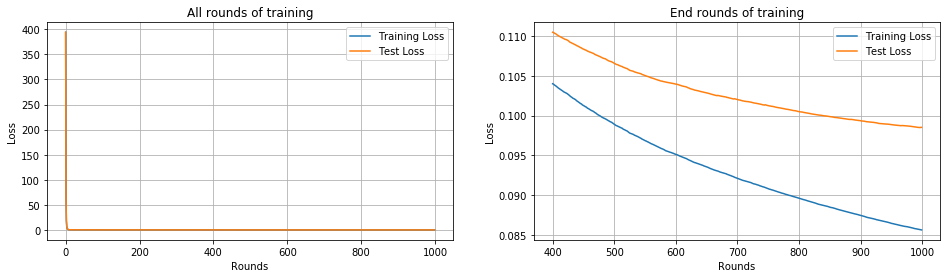

In [75]:
plot_xgb_cv_score(bst_cv1, 1000, 400)

### 基于初始模型计算结果并在kaggle上计算得分

In [76]:
test_sub = test.drop(['Id'],axis=1)
test_sub['StateHoliday_b'] = 0
test_sub['StateHoliday_c'] = 0
test_sub = test_sub[train_val_x.columns]

In [78]:

dtest = xgb.DMatrix(test_sub)

test_probs = gbm.predict(dtest)

In [79]:
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs)})

result.to_csv("Rossmann_submission_xgboost_origin.csv", index=False)

### 在kaggle上計算得分0.12004
